# Main analysis tACS OPM data

In [69]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.signal import hilbert, butter, filtfilt

import mne 
from mne.time_frequency import psd_welch

## check no-TACS data 

In [70]:
## import no-tacs data

data, header=  pyxdf.load_xdf('../recordings/02_06/P06-tacs-R1.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

fs = 1000 # sampling rate 

opm_time_stamps = opm_data['time_stamps'] 


# plt.figure(figsize=(15,10))
# plt.plot(markers_data['time_stamps'][:40], markers_data['time_series'][:40])



In [71]:
## set up the markers information
marker_id_start = 7
marker_id_end = 9
marker_id_trial_end = 2
marker_id_trial_start = 1

markers_data_ts = markers_data['time_stamps']

# get the approximate index in chassis time stamp for start trigger
start_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_start)[0]][0]
diff = start_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
start_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0] 

# get the approximate index in chassis time stamp for end trigger
end_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_end)[0]][0]
diff = end_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
end_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]
num_trials = int((markers_data['time_series'].flatten().shape[0] - 2)/ 2) # divide by two because of start and end markers 


#make epochs time stamps in chassis time
markers_data_cut = markers_data['time_series'].flatten()[1:-1] # remove start and end marker timestamps
markers_data_ts = markers_data_ts[1:-1] #remove start and end marker


index = 1
index_1 = 0 #for feeding epochs_ts


start_markers_ts = markers_data_ts[np.where(markers_data_cut == 1)[0]]
# for ts in markers_data_ts: 
#     epochs_ts[index_1] = ts

epochs_ts_index = np.zeros_like(start_markers_ts, dtype=int) #for start and end
for i, ts in enumerate(start_markers_ts): 
    diff = ts - opm_time_stamps 
    diff_bool = (diff < 0.001) & (diff > 0) 
    epochs_ts_index[i] = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]



In [72]:
## setting up the raw time series data for processing 

adc_diode_idx = 11
# adc_tacs_idx = 0
## There will be _full and _cut, the difference is in the duration cut.
opm_data_full = opm_data['time_series'][:] * 1e-15 #in tesla

# adc_diode_full = opm_data_full[:, adc_diode_idx]

# opm_data_full = np.delete(opm_data_full, adc_diode_idx, 1)

num_channels_w_adcs = opm_data['time_series'][:].shape[1]
num_samples = opm_data_full.shape[0]

# print("Time left in cut raw: %f s" %(opm_data_cut.shape[0]/fs))

# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

# channel_names = np.delete(channel_names, adc_diode_idx)

# channel_types = np.delete(channel_types, adc_diode_idx)


## channels ordering
ref_channels = ['01:01:50', '01:02:50', '01:05:50']

tACS_channel = ['00:00:0']
photodiode_channel = ['01:00:0']


channel_orders = ['00:12:50','00:08:50', '01:04:50'
, '00:11:50', '00:07:50', '01:03:50'
, '00:10:50', '00:06:50', '00:03:50'
, '00:09:50', '00:05:50', '00:01:50']


## create full time-series of the adc_diode

# # checking the flicker timing recorded by the photodiode on the projector
# threshold = min(adc_diode_full) + (max(adc_diode_full) - min(adc_diode_full)) * 0.65


# adc_diode_square = np.where(adc_diode_full > threshold, 1, 0) #square signal
# adc_diode_markers = np.where(adc_diode_full > threshold, 1, 0) # vertical lines


# on = False
# for idx, x in enumerate(adc_diode_square): 
#     if x==1 and not on: ## if this is the first one
#         on = True
#     elif x==1 and on: ## during the on period.
#         adc_diode_square[idx] = 1
#         adc_diode_markers[idx] = 0
#         if idx+1==adc_diode_square.shape[0] or adc_diode_square[idx+1] == 0: ## if this is the last one
#             adc_diode_square[idx] = 0
#             adc_diode_markers[idx] = 1
#             on = False

# # get the timing on between flickers. It should be 0.1 s interval (10hz flicker) + random ITI 
# index_diode_on = np.where(adc_diode_markers == 1)[0] 
# timing_diode = np.diff(opm_time_stamps[index_diode_on])

# ## create a phase time series of the ADC diode (visual stimuli)
# adc_diode_phase = np.angle(hilbert(adc_diode_square), deg=False)

# plt.plot(adc_diode_square[20000:23000])




## fitting photodiode signal

In [73]:
# plt.plot(adc_diode_full[10000:11000])
# from scipy import optimize
# def fit_sin_fixed_freq(tt, yy, freq):
#     '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
#     tt = np.array(tt)
#     yy = np.array(yy)
#     ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
#     Fyy = abs(np.fft.fft(yy))
#     guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
#     guess_amp = np.std(yy) * 2.**0.5
#     guess_offset = np.mean(yy)
#     guess = np.array([guess_amp, 0., guess_offset])
#     def sinfunc(t, A, p, c):  return A * np.sin((2.0*np.pi*freq)*t + p) + c
#     popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=100000)
#     A, p, c = popt
#     #f = w/(2.*np.pi)
#     fitfunc = lambda t: A * np.sin((2.0*np.pi*freq)*t + p) + c
#     plt.plot(fitfunc(tt)[10000:11000])
#     return {"amp": A, "omega": 2.0*np.pi*freq, "phase": p, "offset": c, "freq": freq, "period": 1./freq, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

# def fit_sin(tt, yy):
#     '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
#     tt = np.array(tt)
#     yy = np.array(yy)
#     ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
#     Fyy = abs(np.fft.fft(yy))
#     guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
#     guess_amp = np.std(yy) * 2.**0.5
#     guess_offset = np.mean(yy)
#     guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
#     def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
#     popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=100000)
#     A, w, p, c = popt
#     f = w/(2.*np.pi)
#     fitfunc = lambda t: A * np.sin(w*t + p) + c
#     plt.plot(fitfunc(tt)[:11000])

#     return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}
    
# length = adc_diode_full.shape[0]
# tt = np.arange(length)
# obj = fit_sin_fixed_freq(tt, adc_diode_full, 10)
# print(obj)

# print(markers_data_ts)


## Todo: try to low pass filter the signals and maybe it will fit better? bandpass around 10hz maybe 

## Todo: improve rising and falling edge detection

## Todo: maybe check the timing of the computer generated marker with the photodiode

# from scipy.signal import hilbert
# plt.plot(opm_time_stamps,adc_diode_full)

# for ts in markers_data_ts:
#     plt.axvline(x=ts, color='r')
# plt.axhline(y=threshold, color='g')
# plt.xlim(3625627.70,3625627.85)
# print("about 60-70ms delay")
# # You filter your data. Then you take the results and flip them. The beginning becomes the end and the end the beginning. Then you apply your filter again. Then you flip your data back to its original orientation. The cutoff will be slightly sharper then the original design and there will be no delay – 
# # plt.figure()
# # plt.plot(opm_time_stamps,adc_diode_square)
# # plt.xlim(3625627.70,3625627.85)

# plt.figure()
# plt.plot(opm_time_stamps, np.angle(hilbert(adc_diode_full)))
# plt.xlim(3625627.70,3625627.85)



## another thing, make a title

In [74]:
##make epochs for OPM data and 


#make mne object, maybe for easier filtering or other pre-processing stuff..
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw = mne.io.RawArray(opm_data_full[:].T, info)

## TODO: Look into the reference channels
ref = raw.copy().pick(ref_channels)
raw.drop_channels(ref_channels)
#get the tACS and photodiode mne raw data
raw_tacs = raw.copy().pick_channels(tACS_channel)
raw_photodiode = raw.copy().pick_channels(photodiode_channel)
# raw will only be left with primary channels only
raw.drop_channels(tACS_channel)
raw.drop_channels(photodiode_channel)

raw.reorder_channels(channel_orders)

raw_fil_10 = raw.copy().filter(9,11)
raw_fil_1_30 = raw.copy().filter(1,30)

raw_arr_f10 = raw_fil_10[:][0]
raw_arr_f1_30 = raw_fil_1_30[:][0]
print(raw_arr_f1_30.shape)

num_primary_channels = raw_arr_f10.shape[0] # exlcuding reference and adc

trial_dur = 2000 #2 seconds trial
epo_opm_f10 = np.zeros(shape=[num_primary_channels, num_trials, trial_dur]) #filtered 10hz
epo_opm_f1_30 = np.zeros(shape=[num_primary_channels, num_trials, trial_dur]) #filtered 1 and 30hz

for i, ts_index in enumerate(epochs_ts_index): 
    # print(raw_arr[:, ts_index:ts_index+trial_dur].shape)
    # print(ts_index)
    start = ts_index
    end = ts_index+trial_dur

    epo_opm_f10[:, i, :] = raw_arr_f10[:, start:end]
    epo_opm_f1_30[:, i, :] = raw_arr_f1_30[:, start:end]


Creating RawArray with float64 data, n_channels=17, n_times=76518
    Range : 0 ... 76517 =      0.000 ...    76.517 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

In [75]:
# # ref_arr = ref._data.squeeze()[:, 40000:41000] # look at tACS artifact 1s
# ref_arr = ref._data.squeeze()[:, :] 
# plt.figure(figsize=(20,10))
# plt.plot(ref_arr[0, 10000:20000])
# plt.plot(ref_arr[0, 10000:20000])

# # plt.plot(ref_arr[1, 10000:20000])
# # plt.plot(ref_arr[2, 10000:20000])
# plt.xlabel("time (ms)")
# plt.ylabel("Tesla")

12.252
67.963
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


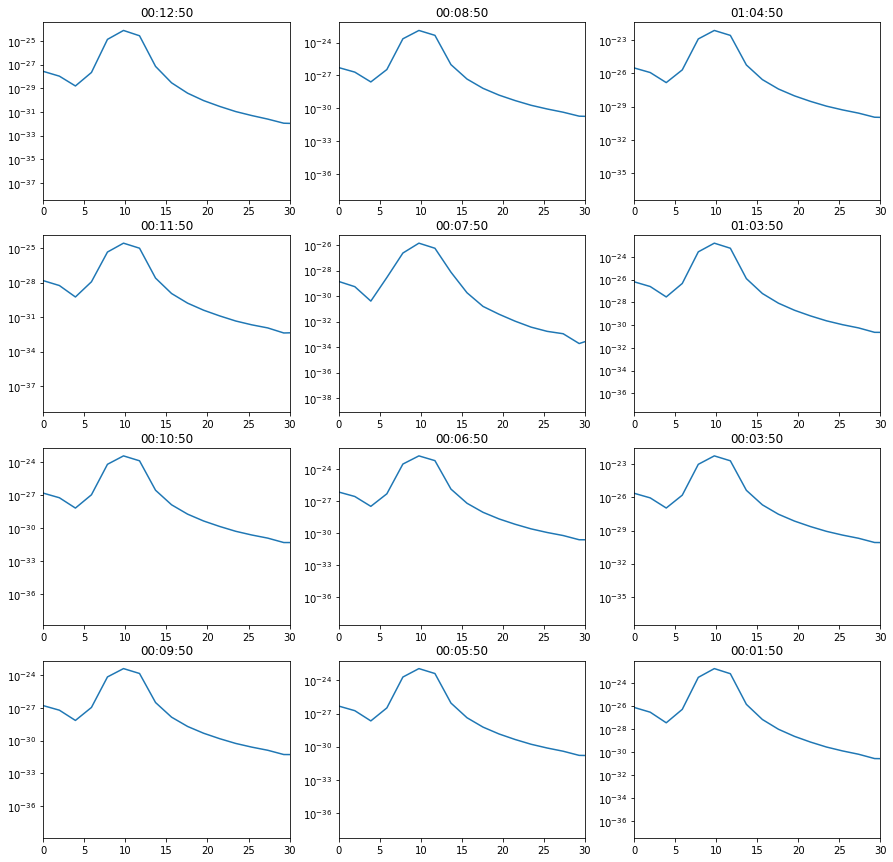

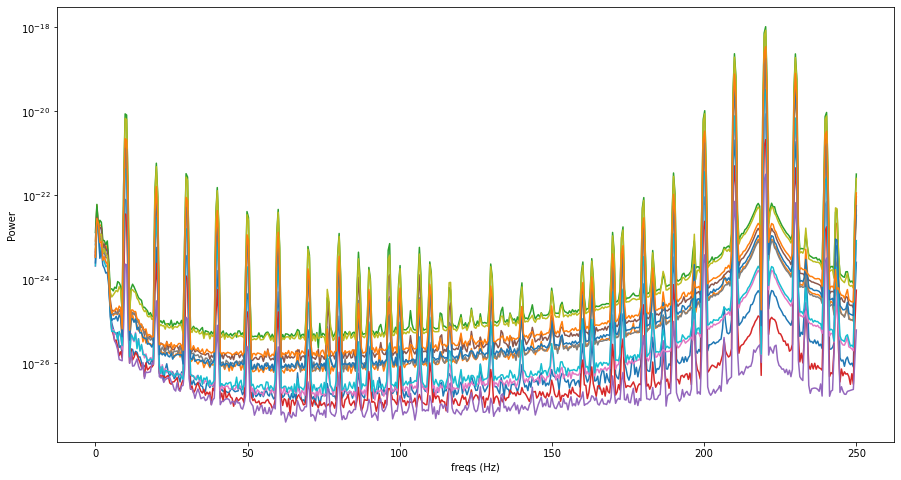

In [76]:
epo_mean = np.mean(epo_opm_f10, axis=1)

# # plot psd OPM data per channel
plt.figure(figsize=(15,15))
for i in range(num_primary_channels):

    f, pxx = signal.welch(epo_mean[i], fs, nperseg=512)
    plt.subplot(4,3,i+1)
    plt.title(channel_orders[i])
    plt.semilogy(f, pxx)
    plt.xlim(0,30)

    # pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
    # plt.semilogy(f, pxx.flatten())
    # plt.xlabel("freqs (Hz)")
    # plt.ylabel("Power")

# %matplotlib inline
plt.figure(figsize=(15,8))
tmin = start_marker_index/fs
tmax = end_marker_index/fs
print(tmin)
print(tmax)
for i in range(num_primary_channels):
    pxx, f = psd_welch(raw, fmin=0, fmax=250, n_fft=2048, picks=channel_orders[i], tmin=tmin, tmax=tmax)
    plt.semilogy(f, pxx.flatten())
    plt.xlabel("freqs (Hz)")
    plt.ylabel("Power")


In [77]:
# ## see the flickers with the OPM data
# %matplotlib inline

# plt.plot(time_stamps[650:1650], opm_data_cut[650:1650,0])
# for i in index_diode_on[:10]:
#     plt.axvline(x=time_stamps[i], color='red')

# ## make a time-series of the visual stimulus

    

In [78]:
# ## prepare OPM data struct

# %matplotlib qt
# info = mne.create_info(list(channel_names), fs, list(channel_types))
# raw = mne.io.RawArray(opm_data_cut[:].T, info)

# ## plot/check reference data
# # ref_data = raw.pick_channels(ref_channels)[:][0]
# # print(ref_data.shape)
# # plt.plot(ref_data[0,:5000])
# # plt.plot(ref_data[1,:5000])
# # plt.plot(ref_data[2,:5000])


# ## Plot PSD of primary channels

# raw.drop_channels(ref_channels)
# raw.reorder_channels(channel_orders)

# # raw.filter(9,12)
# # raw.plot_psd(fmax=30)

# # plot psd OPM data per channel
# for i in range(len(channel_orders)):
#     pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
#     plt.subplot(4,3,i+1)
#     plt.semilogy(f, pxx.flatten())
#     plt.title(channel_orders[i])
#     plt.xlabel("freqs (Hz)")
#     plt.ylabel("Power")



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge:

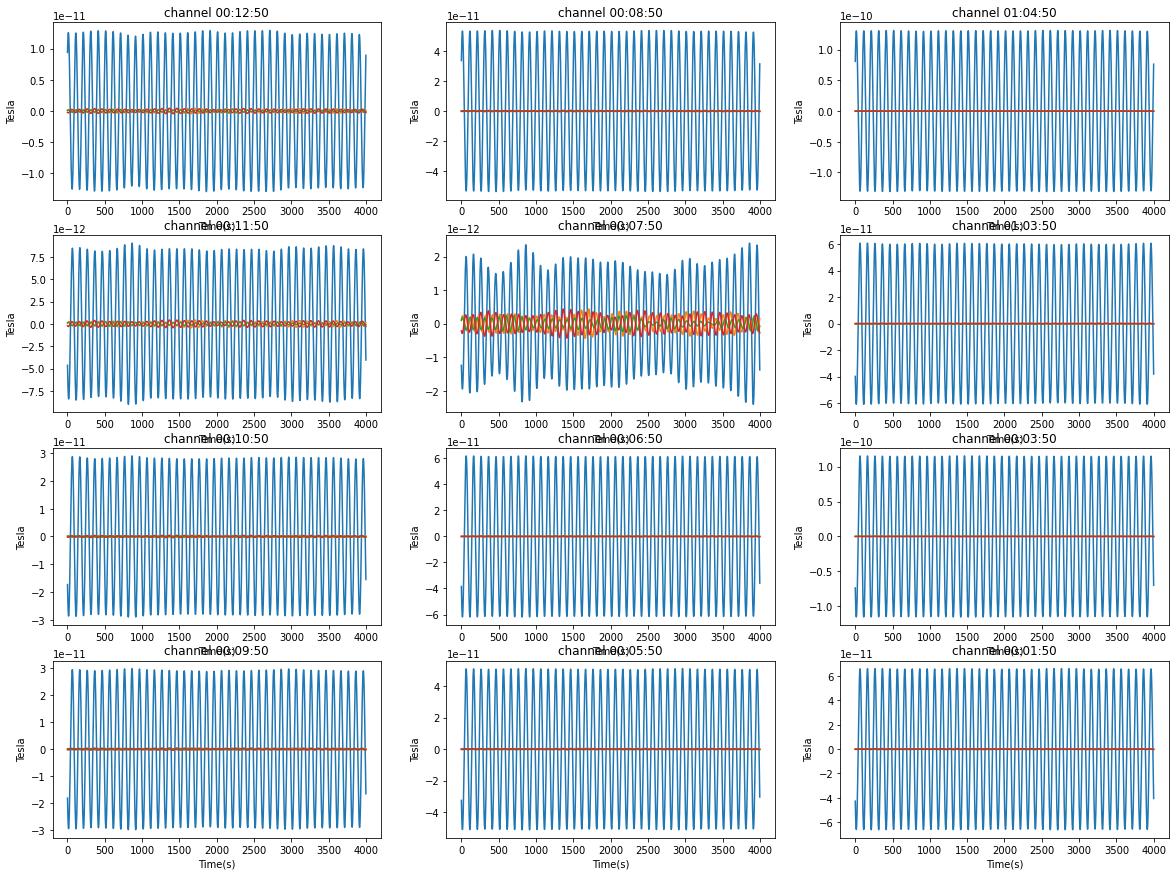

In [79]:
%matplotlib inline
# ## Plot time-series primary channels

# raw.filter(9,11)
# ref.filter(9,11)

# start_marker_index = 10000
# end_marker_index = 50000
raw_arr = raw.filter(9,11).copy()[:][0][:, start_marker_index:end_marker_index]

ref_arr = ref.filter(9,11).copy()[:][0][:, start_marker_index:end_marker_index]
print(ref_arr.shape)

print(raw_arr.shape)

start = 24000
end = 28000

# markers_line = adc_diode_markers[start:end].astype(bool)
# marker_ts = opm_time_stamps[start:end][markers_line]

# Visualize raw data with markers timestamps

plt.figure(figsize=(20,15))
for i in range(raw_arr.shape[0]): 
    plt.subplot(4,3,i+1)
    plt.title('channel ' + raw.ch_names[i])
    plt.plot(raw_arr[i, start:end])
    plt.plot(ref_arr[0, start:end])
    plt.plot(ref_arr[1, start:end])
    plt.plot(ref_arr[2, start:end])


    # plt.ylim((-8e-9,8e-9))
    plt.ylabel('Tesla')
    plt.xlabel('Time(s)')
    # for ts in marker_ts:
    #     # print(time_stamps[j])
    #     plt.axvline(x=ts, c="red")





## Analyze phase information of visual stimuli and OPM data

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)



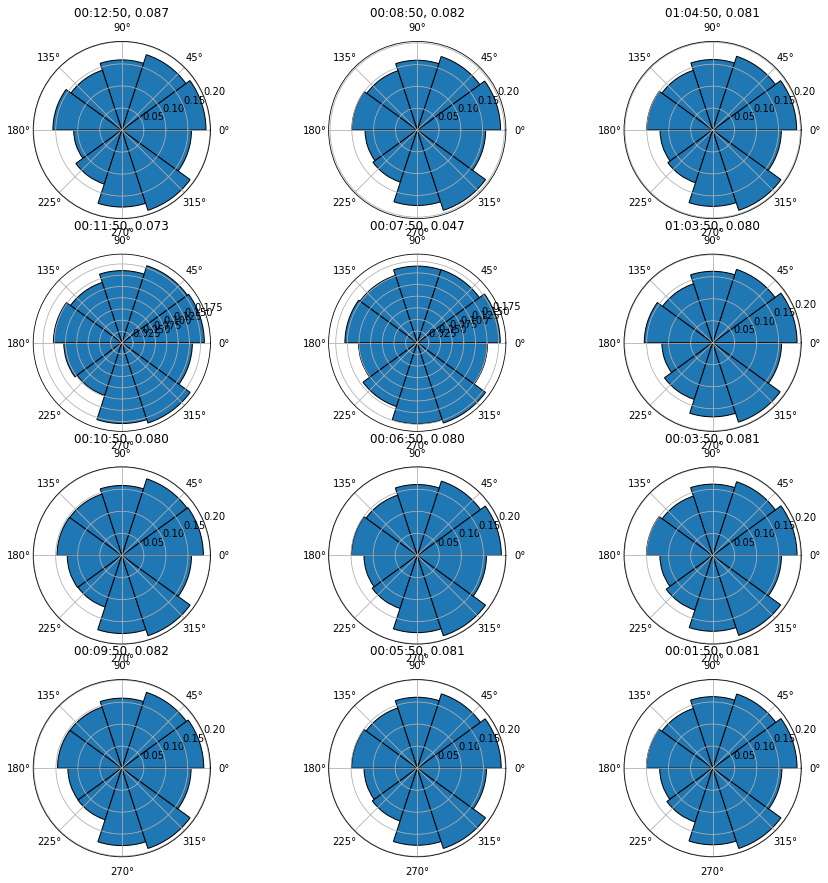

In [80]:
%matplotlib inline
def wrap(phases):
    return (phases + np.pi) % (2 * np.pi) - np.pi

def get_plv(phases):
    plv = (np.exp(1j*phases)).mean()
    return plv

def circ_detrend(phases): 
    # uses Euler's formula to get angle's vector, then get mean angle
    # plv = np.abs(np.sum(complex_phase_diff)/ len(phases))
    # plv= np.abs(np.sum(np.exp(1j*phases))) / len(phases)
    plv = get_plv(phases)
    mean = np.angle(plv)
    return plv, wrap(phases-mean) 


## Make an array of PLVs for each epoch and channel. Maybe not so useful right now. 
# the thing with this is that the random ITI - phase shifts are not incorporated into the epochs. 
# plv_arr = np.zeros(shape=[num_primary_channels, num_trials])
# for ch in range(num_primary_channels):
#     for i in range(num_trials): 
#         opm_angle = np.angle(hilbert(epo_opm_f10[ch, i, :]), deg=False)
#         data = wrap(epo_diode_phase[i] - opm_angle)
#         plv_arr[ch, i] = np.abs(get_plv(data))
    
# print("PLV for channel 9 in all epochs: ", plv_arr[9, :])



## check PLV in the whole time-series, which includes ITI 

# segment to start of experiment and end of experiment time 
raw_arr = raw_fil_10[:][0][:, start_marker_index:end_marker_index]

raw_pd_f10 = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)[:][0][0][start_marker_index:end_marker_index]

flicker_stimulus_phase = np.angle(hilbert(raw_pd_f10), deg=False)

plt.figure(figsize=(15,15))
## for each channel
for i in range(raw_arr.shape[0]): 

    opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
    data = wrap(flicker_stimulus_phase-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw.ch_names[i], np.abs(plv)))





In [81]:




# # plt.plot(raw_tacs[:][0][0,:50000])
# angle1 = np.angle(raw_tacs.copy().filter(39,41, picks=tACS_channel).apply_hilbert(envelope=True, picks=tACS_channel).filter(4,6, picks=tACS_channel).apply_hilbert(envelope=False, picks=tACS_channel)[:][0][0,start_marker_index:end_marker_index])


# plt.figure(figsize=(15,15))
# ## for each channel
# for i in range(raw_arr.shape[0]): 

#     opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
#     data = wrap(angle1-opm_angle)

#     plt.subplot(4,3,i+1, polar=True)
#     # ax.get_yaxis().set_visible(False)
#     plv, detrend_data = circ_detrend(data)

#     plt.hist(detrend_data,density=True,edgecolor='black')
#     plt.title('%s, %.3f' % (raw.ch_names[i], np.abs(plv)))

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

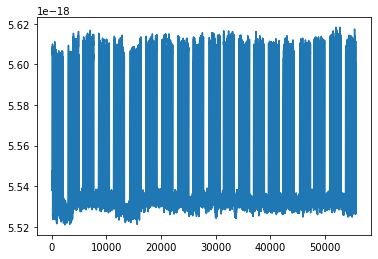

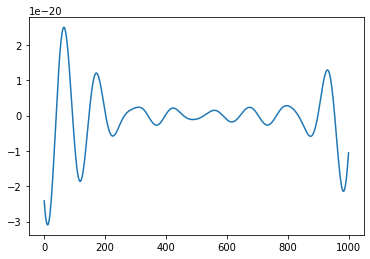

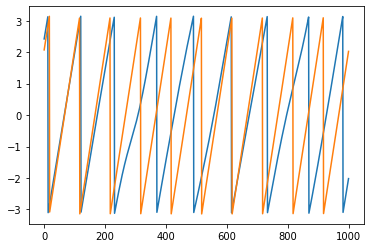

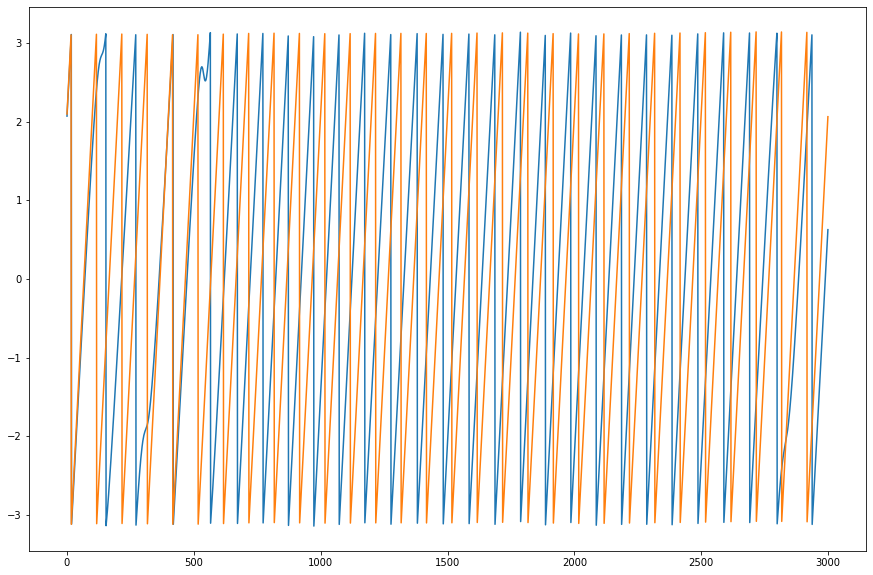

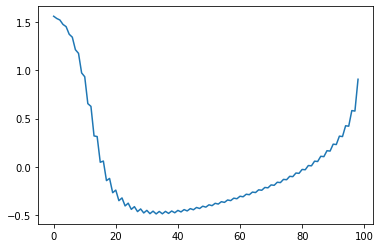

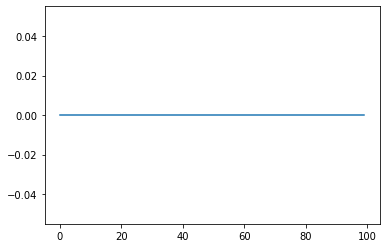

In [82]:


plt.figure()
x = raw_photodiode._data[0, start_marker_index:end_marker_index]
plt.plot(x[:])

x = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)[:][0][0][start_marker_index:end_marker_index]
plt.figure()
plt.plot(x[2000:3000])
# x[2100:2650] = 0

x_angle = wrap(np.angle(hilbert(x)))
y = raw.copy().filter(9,11)[:][0][9, start_marker_index:end_marker_index]
y_angle = wrap(np.angle(hilbert(y)))

plt.figure()
plt.plot(x_angle[2000:3000])
plt.plot(y_angle[2000:3000])


plt.figure(figsize=(15,10))
plt.plot(x_angle[5000:8000])
plt.plot(y_angle[5000:8000])


plt.figure()
x = np.arange(1,100)
# plt.plot(x)
plt.plot(wrap(np.angle(hilbert(x))))


plt.figure()
x = np.ones(100)
# plt.plot(x)
plt.plot(wrap(np.angle(hilbert(x))))

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)



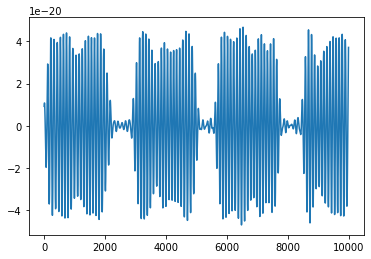

In [83]:
plt.figure()
x = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)[:][0][0][start_marker_index:end_marker_index]
plt.plot(x[:10000])
